In [1]:
import pandas as pd
df = pd.read_excel('result.xlsx')

In [2]:
df

,C1,B2,B1,A2,C2,A1,T(K),time
0,0.242219,2.470929,1.832329,14509.601990,0.044194,40766.670243,85.104240,0
1,0.242188,2.470980,1.832395,14523.769709,0.044233,40750.334563,85.104240,0
2,0.242102,2.470938,1.832317,14518.843162,0.044176,40752.380175,85.104240,1
3,0.242224,2.470963,1.832326,14507.076815,0.044298,40772.963380,85.104240,1
4,0.242099,2.470956,1.832378,14501.070953,0.044221,40760.665491,85.104240,1
...,...,...,...,...,...,...,...,...
33031,0.241451,2.440609,1.790072,11101.840651,0.045353,24873.929758,270.605904,8512
33032,0.241025,2.440607,1.790090,11085.750082,0.045202,24844.783576,270.631720,8512
33033,0.241083,2.440621,1.790078,11055.033872,0.045216,24843.067925,270.631720,8513
33034,0.241071,2.440599,1.790130,11115.846743,0.045035,24848.428355,270.605904,8513


In [4]:
# Считываем данные из файла
filename = "data/sp_00070000.sp"
data = {"E": [], "I(E)": [], "I(l)": []}
with open(filename, 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        values = line.split()
        data["I(l)"].append(float(values[1]))
        data["I(E)"].append(float(values[3]))

# Преобразуем данные в массивы NumPy
x_data = np.array(data["I(E)"])
y_data = np.array(data["I(l)"])



# Упорядочиваем x_data
sorted_indices = np.argsort(x_data)
x_data = x_data[sorted_indices]
y_data = y_data[sorted_indices]

# Заменяем значения в y диапазоне по x от 2.9 до 3.2 минимальным значением в этом диапазоне
min_y_value = np.min(y_data[(x_data >= 2.9) & (x_data <= 3.2)])
y_data[(x_data >= 2.9) & (x_data <= 3.2)] = min_y_value

# Ограничиваем x_data до 5
mask = x_data <= 4
x_data = x_data[mask]
y_data = y_data[mask]
y_data = y_data - min(y_data)

In [6]:
# Define the ranges
x1_min, x1_max = 1, 2.36
x2_min, x2_max = 2.36, 2.57

# Boolean indexing to select values within the ranges
x1_data = x_data[(x_data >= x1_min) & (x_data <= x1_max)]
x2_data = x_data[(x_data >= x2_min) & (x_data <= x2_max)]

In [7]:
import numpy as np

# Define the Gaussian functions
def gaussian1(x, A1, B1, C1):
    return A1 * np.exp(-(x - B1)**2 / (C1**2))

def gaussian2(x, A2, B2, C2):
    return A2 * np.exp(-(x - B2)**2 / (C2**2))

# Define the function to calculate the area under the curve using the trapezoidal rule
def calculate_area(x, y):
    dx = np.diff(x)
    y_avg = (y[1:] + y[:-1]) / 2
    area = np.sum(dx * y_avg)
    return area

# Assuming x values are the same for both curves
#x = np.array(...)  # Use your x values from the DataFrame

# Function to calculate area for each row
def calculate_areas(x1_data, x2_data, row):
    S1 = calculate_area(x1_data, gaussian1(x1_data, row['A1'], row['B1'], row['C1']))
    S2 = calculate_area(x2_data, gaussian2(x2_data, row['A2'], row['B2'], row['C2']))
    return S1, S2

# Apply the function to each row of the DataFrame
df[['S1', 'S2']] = df.apply(lambda row: pd.Series(calculate_areas(x1_data, x2_data, row)), axis=1)


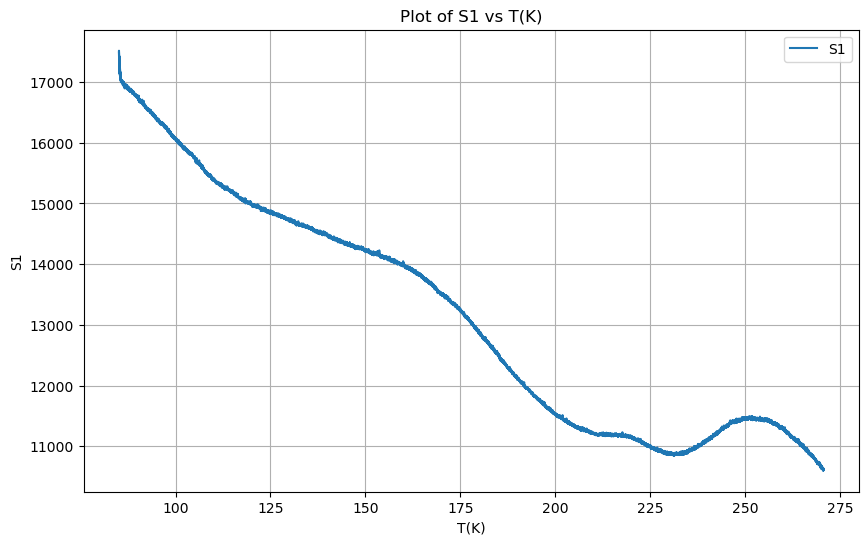

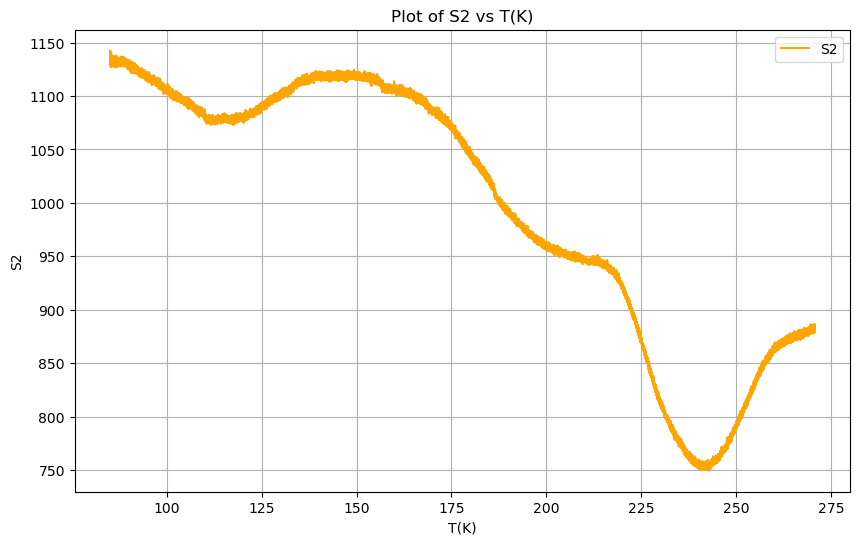

In [10]:
import matplotlib.pyplot as plt

# Assuming you have already calculated S1 and S2 and stored them in df

# Plot S1 vs T(K)
plt.figure(figsize=(10, 6))
plt.plot(df['T(K)'], df['S1'], label='S1')

plt.xlabel('T(K)')
plt.ylabel('S1')
plt.title('Plot of S1 vs T(K)')
plt.legend()
plt.grid(True)
plt.show()

# Plot S2 vs T(K)
plt.figure(figsize=(10, 6))
plt.plot(df['T(K)'], df['S2'], label='S2', color='orange')
plt.xlabel('T(K)')
plt.ylabel('S2')
plt.title('Plot of S2 vs T(K)')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
df.to_excel('result.xlsx', index = False)

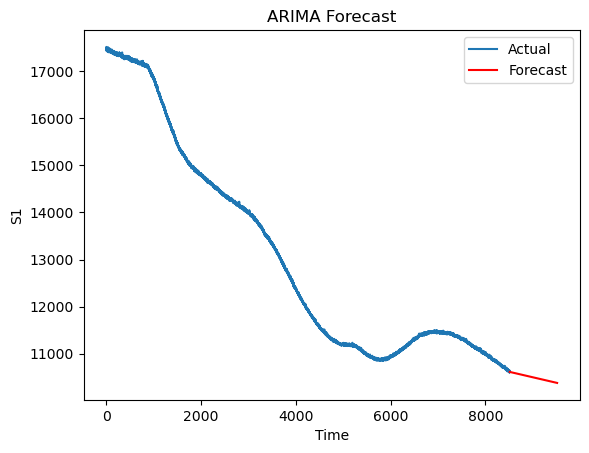

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming df is your DataFrame with 'time' and 'S1' columns
X = df['time'].values
y = df['S1'].values

# Соответствующим образом определите порядок модели ARIMA (p, d, q)
order = (2, 2, 3)

# Fit ARIMA model
model = ARIMA(y, order=order)
fit_model = model.fit()

# Forecast
forecast_steps = 1000
forecast = fit_model.forecast(steps=forecast_steps)

# Plotting
plt.plot(X, y, label='Actual')
plt.plot(range(max(X), max(X) + forecast_steps), forecast, color='red', label='Forecast')
plt.xlabel('Time')
plt.ylabel('S1')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

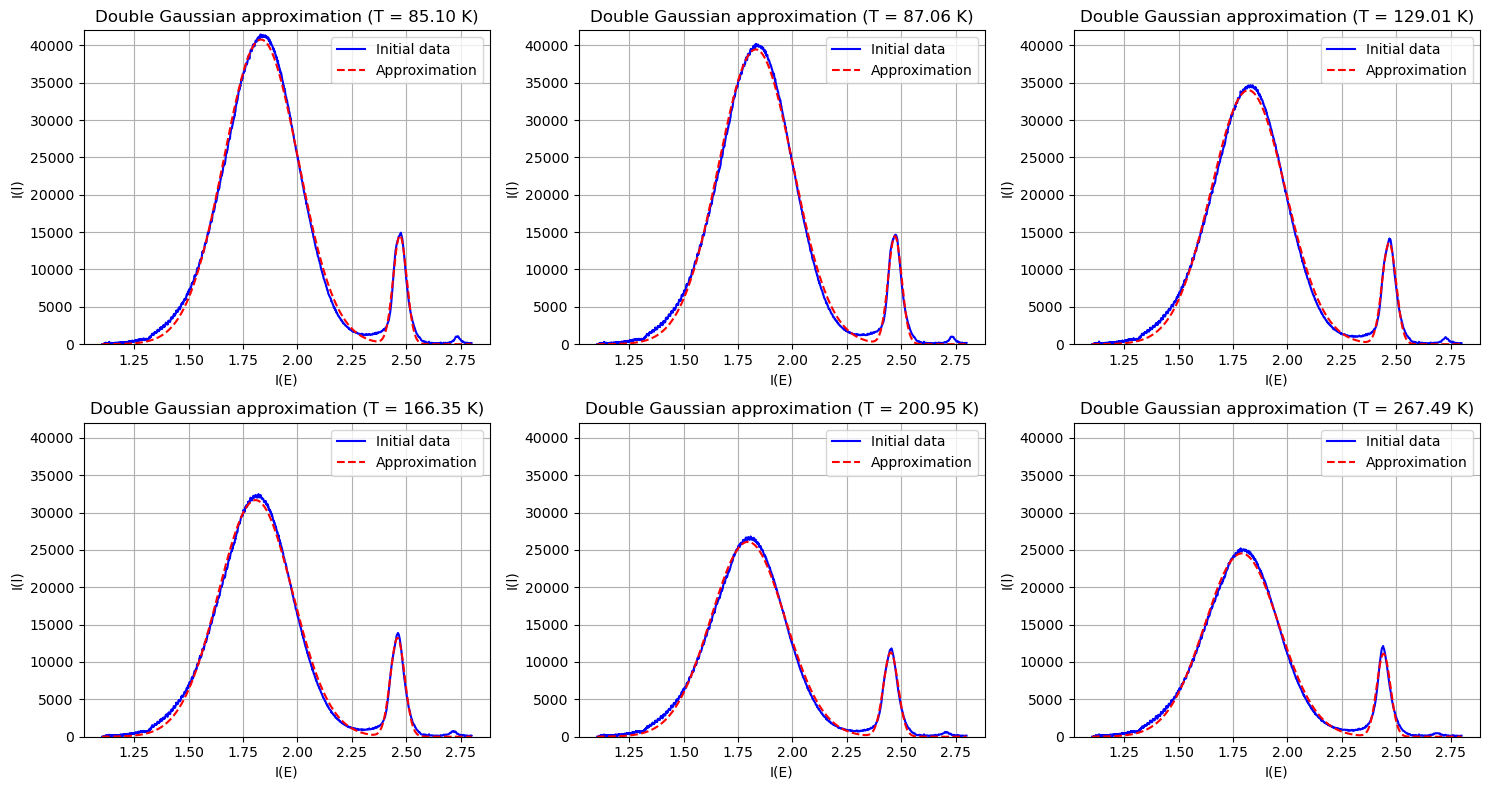

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

data_ = pd.read_csv('data+.csv')

# Функция для двух гауссиан
def double_gaussian(x, A1, B1, C1, A2, B2, C2):
    return A1 * np.exp(-(x - B1)**2 / (C1**2)) + A2 * np.exp(-(x - B2)**2 / (C2**2))

# Создаем область для рисования
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Список файлов
files = ["data/sp_00040000.sp", "data/sp_00045000.sp", "data/sp_00050000.sp", 
         "data/sp_00055000.sp", "data/sp_00060000.sp", "data/sp_00072000.sp"]

# Проходим по каждому файлу и строим график
for i, filename in enumerate(files):
    # Считываем данные из файла
    data = {"E": [], "I(E)": [], "I(l)": []}
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('#'):
                if line.startswith('# T = '):
                    temp = float(line.split('=')[1].strip().split()[0])
                continue
            values = line.split()
            data["I(l)"].append(float(values[1]))
            data["I(E)"].append(float(values[3]))

    # Преобразуем данные в массивы NumPy
    x_data = np.array(data["I(E)"])
    y_data = np.array(data["I(l)"])

    # Упорядочиваем x_data
    sorted_indices = np.argsort(x_data)
    x_data = x_data[sorted_indices]
    y_data = y_data[sorted_indices]

    # Заменяем значения в y диапазоне по x от 2.9 до 3.2 минимальным значением в этом диапазоне
    min_y_value = np.min(y_data[(x_data >= 2.9) & (x_data <= 3.2)])
    y_data[(x_data >= 2.9) & (x_data <= 3.2)] = min_y_value

    # Ограничиваем x_data до 5
    mask = x_data <= 2.8
    x_data = x_data[mask]
    y_data = y_data[mask]
    y_data = y_data - min(y_data)
    
    scale_f = data_[data_['Filename'] == os.path.basename(filename)]['Scale Factor_'].values[0]
    y_data = y_data/scale_f

    # Начальные значения параметров для аппроксимации
    initial_guess = [max(y_data), 1.7, 10, max(y_data)/3, 2.45, 0.01]

    # Аппроксимация данных двумя гауссианами
    popt, pcov = curve_fit(double_gaussian, x_data, y_data, p0=initial_guess)

    # Получение параметров гауссиан
    A1, B1, C1, A2, B2, C2 = popt

    # Построение графика в соответствующем подрисунке
    axs[i//3, i%3].plot(x_data, y_data, 'b-', label='Initial data')
    axs[i//3, i%3].plot(x_data, double_gaussian(x_data, A1, B1, C1, A2, B2, C2), 'r--', label='Approximation')
    axs[i//3, i%3].set_xlabel('I(E)')
    axs[i//3, i%3].set_ylabel('I(l)')
    axs[i//3, i%3].set_title(f'Double Gaussian approximation (T = {temp:.2f} K)')
    axs[i//3, i%3].legend()
    axs[i//3, i%3].set_ylim(0, 42000)
    axs[i//3, i%3].grid(True)

# Регулируем расстояние между подрисунками
plt.tight_layout()

# Сохраняем и отображаем график
plt.savefig('subfigures_2x3.pdf')
plt.show()


In [6]:
import pandas as pd
data_ = pd.read_csv('data+.csv')

In [14]:
data_[data_['Filename'] == os.path.basename(filename)]['Scale Factor_'].values[0]

1.5608465608465607

In [11]:
import os
os.path.basename(filename)

'sp_00070000.sp'

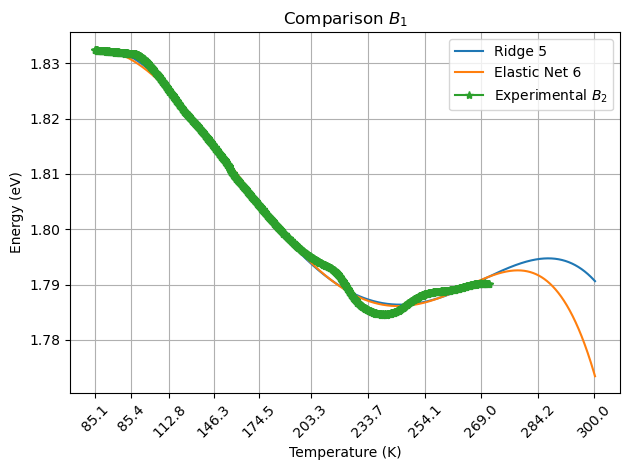

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds4 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Ridge\Ridge_5.xlsx')
preds5 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Elastic Net\Elastic Net_6.xlsx')


# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds4['Time (s)'], preds4['B1'], label='Ridge 5')
plt.plot(preds5['Time (s)'], preds5['B1'], label='Elastic Net 6')

# Plot df['S1'] vs temperature from df_new
plt.plot(df['Time (s)'], df['B1'], label='Experimental $B_2$', marker='*')

# Select 10 evenly spaced temperature values
temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)

# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Energy (eV)')
plt.title('Comparison $B_1$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('B1_sugg.pdf')
plt.show()


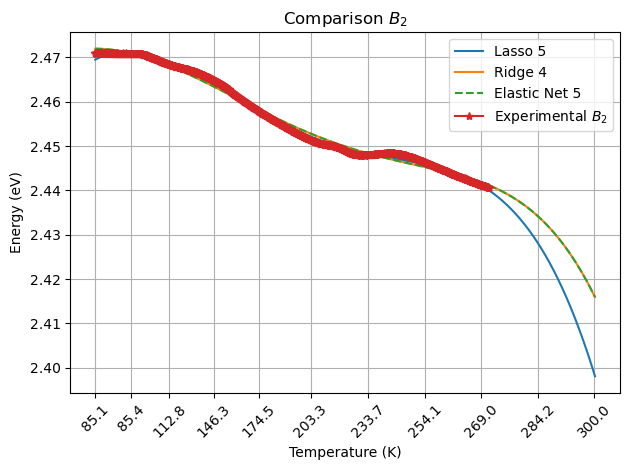

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds1 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Ridge\Ridge_4.xlsx')
preds2 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Lasso\Lasso_5.xlsx')
preds3 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Elastic Net\Elastic Net_5.xlsx')



# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds1['Time (s)'], preds1['B2'], label='Lasso 5')
plt.plot(preds2['Time (s)'], preds2['B2'], label='Ridge 4', linestyle='-')
plt.plot(preds2['Time (s)'], preds2['B2'], label='Elastic Net 5', linestyle='--')

# Plot df['S1'] vs temperature from df_new
plt.plot(df['Time (s)'], df['B2'], label='Experimental $B_2$', marker='*')

# Select 10 evenly spaced temperature values
temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)

# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Energy (eV)')
plt.title('Comparison $B_2$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('B2_sugg.pdf')
plt.show()


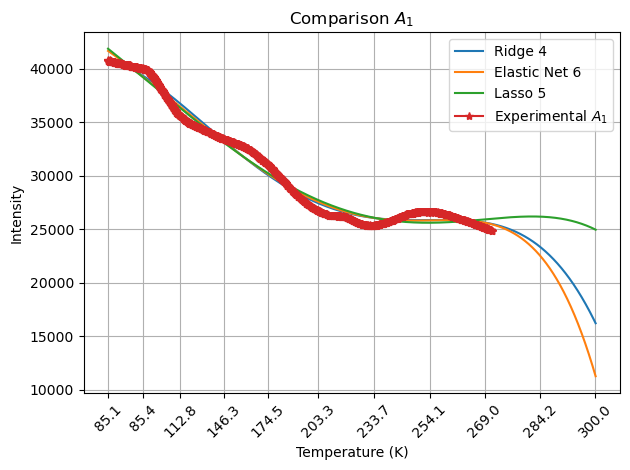

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds6 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Ridge\Ridge_4.xlsx')
preds7 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Elastic Net\Elastic Net_6.xlsx')
preds8 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Lasso\Lasso_5.xlsx')

# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds6['Time (s)'], preds6['A1'], label='Ridge 4')
plt.plot(preds7['Time (s)'], preds7['A1'], label='Elastic Net 6')
plt.plot(preds8['Time (s)'], preds8['A1'], label='Lasso 5')

# Plot df['S1'] vs temperature from df_new
plt.plot(df['Time (s)'], df['A1'], label='Experimental $A_1$', marker='*')

# Select 10 evenly spaced temperature values
temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)

# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Intensity')
plt.title('Comparison $A_1$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('A1_sugg.pdf')
plt.show()


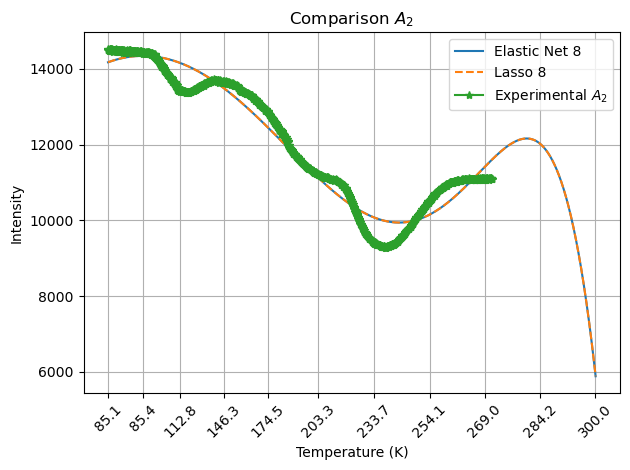

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds9 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Elastic Net\Elastic Net_8.xlsx')
preds10 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Lasso\Lasso_8.xlsx')

# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds9['Time (s)'], preds9['A2'], label='Elastic Net 8', linestyle='-')
plt.plot(preds10['Time (s)'], preds10['A2'], label='Lasso 8', linestyle='--')

# Plot df['S1'] vs temperature from df_new
plt.plot(df['Time (s)'], df['A2'], label='Experimental $A_2$', marker='*')

# Select 10 evenly spaced temperature values
temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)

# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Intensity')
plt.title('Comparison $A_2$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('A2_sugg.pdf')
plt.show()


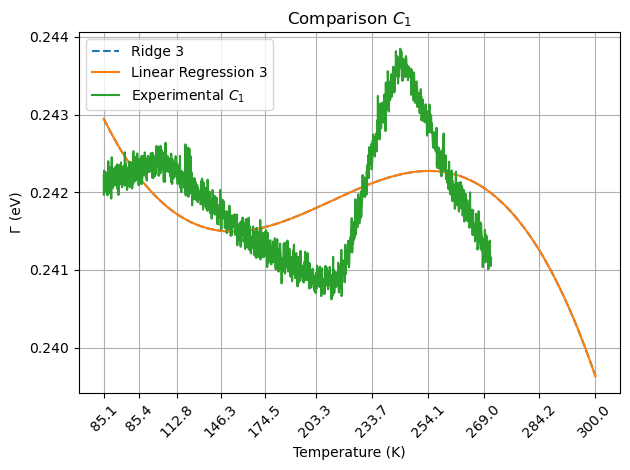

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds11 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Ridge\Ridge_3.xlsx')
preds12 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Linear Regression\Linear Regression_3.xlsx')


# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds11['Time (s)'], preds11['C1'], label='Ridge 3', linestyle='--')
plt.plot(preds12['Time (s)'], preds12['C1'], label='Linear Regression 3', linestyle='-')


# Plot df['S1'] vs temperature from df_new
plt.plot(df['Time (s)'], df['C1'], label='Experimental $C_1$')

# Select 10 evenly spaced temperature values
temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)

# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Г (eV)')
plt.title('Comparison $C_1$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('C1_sugg.pdf')
plt.show()


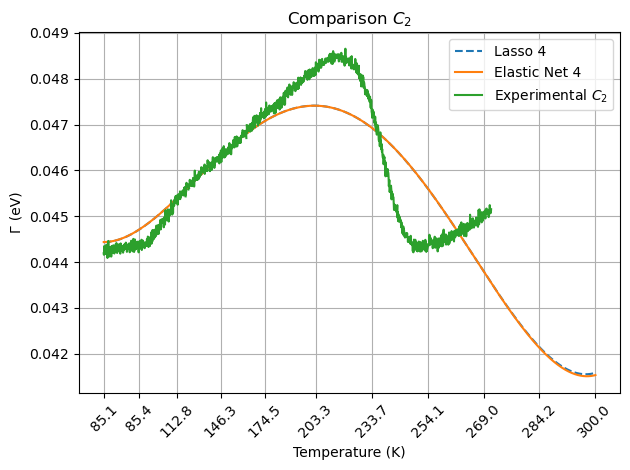

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds13 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Lasso\Lasso_4.xlsx')
preds14 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Elastic Net\Elastic Net_4.xlsx')


# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds13['Time (s)'], preds13['C2'], label='Lasso 4', linestyle='--')
plt.plot(preds14['Time (s)'], preds14['C2'], label='Elastic Net 4', linestyle='-')


# Plot df['S1'] vs temperature from df_new
plt.plot(df['Time (s)'], df['C2'], label='Experimental $C_2$')

# Select 10 evenly spaced temperature values
temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)

# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Г (eV)')
plt.title('Comparison $C_2$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('C2_sugg.pdf')
plt.show()


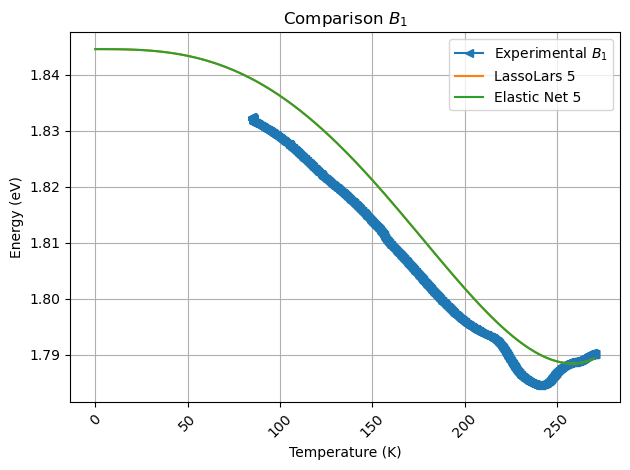

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('Extra_.xlsx')
df_ = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

preds_r1 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra revers\Elastic Net\Elastic Net_5.xlsx')
preds_r2 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra revers\LassoLars\LassoLars_5.xlsx')

#preds4 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Ridge\Ridge_5.xlsx')
#preds5 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models\Elastic Net\Elastic Net_6.xlsx')


# Plot preds2['Area'] vs temperature from df_new
plt.plot(df_['T(K)'], df_['B1'], label='Experimental $B_1$', marker='<')

plt.plot(preds_r2['temp'], preds_r2['B1'], label='LassoLars 5')
plt.plot(preds_r2['temp'], preds_r2['B1'], label='Elastic Net 5')


#plt.plot(preds4['Time (s)'], preds4['B1'], label='Ridge 5')
#plt.plot(preds5['Time (s)'], preds5['B1'], label='Elastic Net 6')


# Plot df['S1'] vs temperature from df_new
#plt.plot(df['Time (s)'], df['B1'], label='Experimental $B_2$', marker='*')

# Select 10 evenly spaced temperature values
'''temp_values = df_new['T(K)'].round(1)
step = max(len(temp_values) // 10, 1)  # Determine step size
temp_values = temp_values[::step]  # Select every 'step' value

# Set temperature values as x-axis ticks
plt.xticks(df_new['Time (s)'][::step], temp_values)
'''
# Set labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Energy (eV)')
plt.title('Comparison $B_1$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
#plt.savefig('B1_sugg.pdf')
plt.show()


C:\Users\ivan\AppData\Local\Temp\ipykernel_7576\3290282169.py:12: RuntimeWarning: divide by zero encountered in divide
  return E_0 - 2 * a * (np.exp(theta / T) - 1)**(-1)


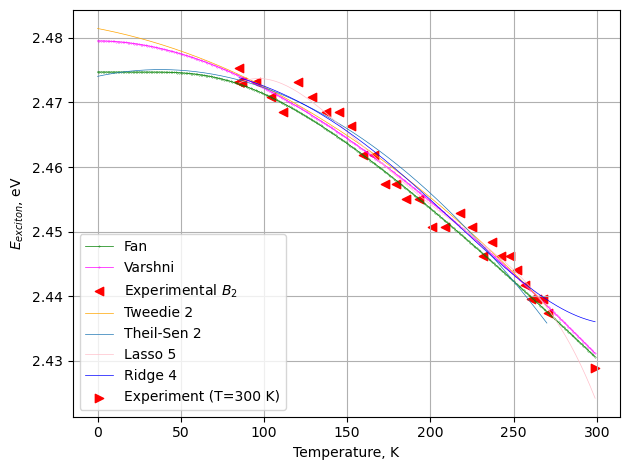

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_excel('Extra_.xlsx')
df_ = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')

temp = np.arange(0, 300, 1)

def equation(T, E_0, a, theta):
    return E_0 - 2 * a * (np.exp(theta / T) - 1)**(-1)

def equation2(T, E_0_, a1, a2):
    return E_0_ - a1*T**2/(a2+T)

E_0, a, theta = [2.490310877724915, 0.001812257423236856, 18.998718583672918]
E_0, a, theta = [2.474710877724915, 0.044423855662686654, 330.10415111942746]

E_0_, a1, a2 = [2.483277179179585, 0.00015020318274801443, 11.404708949055259]
E_0_, a1, a2 = [2.4795234354026072, 4.155497044502688E-4, 469.5156368424212]

predict= equation(temp, E_0, a, theta)
predict2= equation2(temp, E_0_, a1, a2)


preds1 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Ridge\Ridge_4.xlsx')
preds2 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Lasso\Lasso_5.xlsx')
preds3 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Elastic Net\Elastic Net_5.xlsx')


preds_r3 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra revers\Tweedie\Tweedie_2.xlsx')
preds_r4 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra revers\Theil-Sen\Theil-Sen_2.xlsx')


plt.plot(temp, predict, label='Fan', color='green', marker='.', linewidth=0.5, markersize=0.5)
plt.plot(temp, predict2, label='Varshni', color='magenta', marker='.', linewidth=0.5, markersize=0.5)
plt.scatter(df['temp'], df['B2'], label='Experimental $B_2$', marker='<', color='red')
#plt.scatter(df_['T(K)'], df_['B2'], label='Experimental $B_2$', marker='*')

plt.plot(preds_r3['temp'], preds_r3['B2'], label='Tweedie 2', color='orange', linewidth=0.5)
plt.plot(preds_r4['temp'], preds_r4['B2'], label='Theil-Sen 2', linewidth=0.5)

# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds1['temp'], preds1['B2'], label='Lasso 5', color='pink', linewidth=0.5)
plt.plot(preds2['temp'], preds2['B2'], label='Ridge 4', linestyle='-', color='blue', linewidth=0.5)
#plt.plot(preds2['temp'], preds2['B2'], label='Elastic Net 5', linestyle='--')

# Add the single point
plt.scatter(298.764491, 2.4288928598137036, color='red', marker='>', label='Experiment (T=300 K)')


plt.xlabel('Temperature, K')
plt.ylabel('$E_{exciton}$, eV')
#plt.title('Comparison $B_2$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('B2_sugg_.pdf')
plt.show()


C:\Users\ivan\AppData\Local\Temp\ipykernel_7576\478196678.py:13: RuntimeWarning: divide by zero encountered in divide
  return E_0 - 2 * a * (np.exp(theta / T) - 1)**(-1)


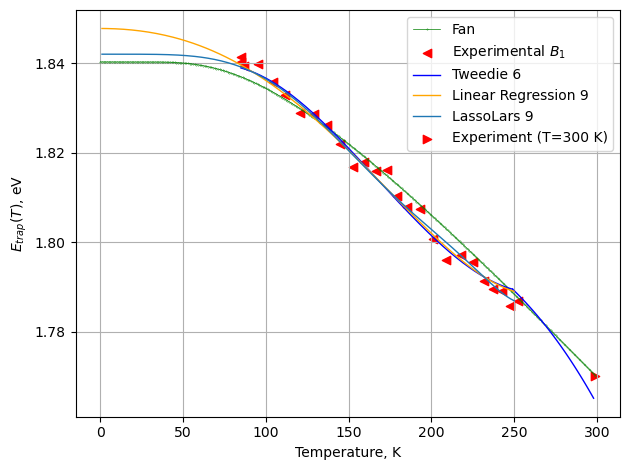

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_excel('Extra__.xlsx')
df_ = pd.read_excel('result_.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')
df1 = pd.read_excel('Traps_bandgap_Temp_new.xlsx')

temp = np.arange(0, 300, 1)

def equation(T, E_0, a, theta):
    return E_0 - 2 * a * (np.exp(theta / T) - 1)**(-1)

def equation2(T, E_0_, a1, a2):
    return E_0_ - a1*T**2/(a2+T)


E_0, a, theta = [1.840354411336589, 0.0648669335702127, 313.2644742237531]

E_0_, a1, a2 = [1.8537398324467222, 0.0002690597203342576, -0.07979110814628186]

predict= equation(temp, E_0, a, theta)

predict2= equation2(temp, E_0_, a1, a2)


#preds1_ = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\RANSAC\RANSAC_9.xlsx')
#preds2_ = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Ridge\Ridge_7.xlsx')
preds2 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Tweedie\Tweedie_6.xlsx')
preds1 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Tweedie\Tweedie_3.xlsx')

preds_r3 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra revers\Elastic Net\Elastic Net_5.xlsx')
preds_r4 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra revers\LassoLars\LassoLars_9.xlsx')


plt.plot(temp, predict, label='Fan', color='green', marker='.', linewidth=0.5, markersize=0.5)
#plt.plot(temp, predict2, label='Varshni', color='magenta', marker='.', linewidth=0.5, markersize=0.5)
#plt.scatter(df1['Temp'], df1['B1'], label='Experimental $B_1$', marker='<', color='red')
#plt.scatter(df['temp'][22:], df['B1'][22:].rolling(window=10, min_periods=1).mean(), label='Experimental $B_1$', marker='<', color='red')
plt.scatter(df['temp'][0:26], df['B1'][0:26], label='Experimental $B_1$', marker='<', color='red')

#plt.scatter(df_['T(K)'][::30], df_['B1'][::30]+0.0065, label='Experimental $B_1$', marker='<', color='red')



# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds1['temp'][0:165], preds1['B1'][0:165], color='blue', linewidth=1)
plt.plot(preds2['temp'][164:214], preds2['B1'][164:214]-0.0027, label='Tweedie 6', linestyle='-', color='blue', linewidth=1)
#plt.plot(preds2['temp'], preds2['B2'], label='Elastic Net 5', linestyle='--')

plt.plot(preds_r3['temp'][20:270], preds_r3['B1'][20:270], label='Linear Regression 9', color='orange', linewidth=1)
plt.plot(preds_r4['temp'][20:270], preds_r4['B1'][20:270], label='LassoLars 9', linewidth=1)

# Add the single point
plt.scatter(298.764491, 1.7702288375912183, color='red', marker='>', label='Experiment (T=300 K)')


plt.xlabel('Temperature, K')
plt.ylabel('$E_{trap}(T)$, eV')
#plt.title('position of the trap-state luminescence maximum')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('B1_sugg_.pdf')
plt.show()


In [14]:
df['B1']

0     1.84029
1     1.84151
2     1.83934
3     1.83983
4     1.83584
5     1.83297
6     1.82899
7     1.82876
8     1.82634
9     1.82211
10    1.81691
11    1.81792
12    1.81592
13    1.81627
14    1.81032
15    1.80784
16    1.80750
17    1.80085
18    1.79613
19    1.79729
20    1.79572
21    1.79129
22    1.78957
23    1.78916
24    1.78572
25    1.78687
26    1.78729
27    1.78572
28    1.78926
Name: B1, dtype: float64

In [41]:
preds_r4 

,Unnamed: 0,temp,S1,B1,B2
0,0,270,11889.904868,1.792060,2.437803
1,1,269,11915.140864,1.791174,2.438291
2,2,268,11938.082844,1.790383,2.438762
3,3,267,11958.843475,1.789681,2.439216
4,4,266,11977.534615,1.789064,2.439652
...,...,...,...,...,...
266,266,4,18372.346292,1.842073,2.472621
267,267,3,18372.346371,1.842073,2.472621
268,268,2,18372.346393,1.842073,2.472621
269,269,1,18372.346396,1.842073,2.472621


PermissionError: [Errno 13] Permission denied: 'S_sugg_.pdf'

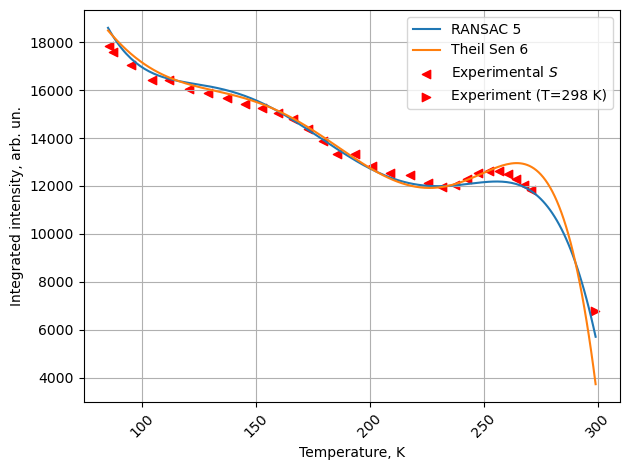

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df__ = pd.read_excel('Extra__.xlsx')
df = pd.read_excel('Integral_Intensity_all_Temp.xlsx')
df_new= pd.read_excel('temp_extr.xlsx')


preds1 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\RANSAC\RANSAC_5.xlsx')
preds2 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Theil-Sen\Theil-Sen_6.xlsx')

                        
#preds6 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Ridge\Ridge_4.xlsx')
#preds7 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Elastic Net\Elastic Net_6.xlsx')
#preds8 = pd.read_excel(r'C:\Users\ivan\WORK\CdSe\models extra\Lasso\Lasso_5.xlsx')

# Plot preds2['Area'] vs temperature from df_new
plt.plot(preds1['temp'], preds1['S1'], label='RANSAC 5')
plt.plot(preds2['temp'], preds2['S1'], label='Theil Sen 6')
#plt.plot(preds8['temp'], preds8['S1'], label='Lasso 5')

# Create a copy of the 'S' column to modify
S_modified = df['S'].copy()

# Subtract 600 from the first 100 elements
S_modified.loc[:99] -= 550

# Subtract 680 from the remaining elements
S_modified.loc[100:] -= 700
# Now plot the modified values
plt.scatter(df['Temp'], S_modified, label='Experimental $S$', marker='<', color='red')


#plt.scatter(df['Temp'], df['S']-680, label='Experimental $S$', marker='<', color='red')

# Add the single point
plt.scatter(298.764491, 6770.2288375912183, color='red', marker='>', label='Experiment (T=298 K)')

# Set labels and title
plt.xlabel('Temperature, K')
plt.ylabel('Integrated intensity, arb. un.')
#plt.title('Comparison $S$')

# Show the legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid()
plt.tight_layout()
plt.savefig('S_sugg_.pdf')
plt.show()


In [3]:
preds1

,Unnamed: 0,temp,S1,B1,B2
0,0,85,18600.698626,1.839092,2.473224
1,1,86,18433.954523,1.839089,2.473198
2,2,87,18277.025521,1.839065,2.473173
3,3,88,18129.483627,1.839020,2.473151
4,4,89,17990.911168,1.838955,2.473129
...,...,...,...,...,...
210,210,295,7281.252357,1.829745,2.412812
211,211,296,6916.193330,1.832308,2.411263
212,212,297,6531.965171,1.834975,2.409658
213,213,298,6127.919108,1.837749,2.407994


In [2]:
preds2

,Unnamed: 0,temp,S1,B1,B2
0,0,85,18488.548960,1.832296,2.467675
1,1,86,18378.024405,1.833587,2.469034
2,2,87,18270.506744,1.834747,2.470258
3,3,88,18166.023115,1.835784,2.471355
4,4,89,18064.592413,1.836702,2.472333
...,...,...,...,...,...
210,210,295,6371.478582,2.012223,2.337799
211,211,296,5768.946519,2.023220,2.330116
212,212,297,5128.114633,2.034607,2.322006
213,213,298,4447.401089,2.046393,2.313452
